In [48]:
!pip install diffusers -q
import torch
import torchvision
import random
from diffusers import DDPMScheduler, UNet2DModel, UNet2DConditionModel 
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, Subset, Dataset
from tqdm.auto import tqdm
import sys
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from collections import defaultdict
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
sys.path.append('/kaggle/input/gan-lib')

Using device: cuda


In [3]:
def set_seed(seed: int = 42):
    random.seed(seed)  # Фиксируем seed для встроенного генератора Python
    np.random.seed(seed)  # Фиксируем seed для NumPy
    torch.manual_seed(seed)  # Фиксируем seed для PyTorch (CPU)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # Фиксируем seed для PyTorch (CUDA)
        torch.cuda.manual_seed_all(seed)  # Фиксируем seed для всех доступных GPU
        torch.backends.cudnn.deterministic = True  # Гарантируем детерминированность CUDNN
        torch.backends.cudnn.benchmark = False  # Отключаем эвристику для оптимизации скорости

# Вызов функции для установки seed
set_seed(0x3df3fa)

In [4]:
file_path = "/kaggle/input/unet-plus-model/generated_data.npz"
data = np.load(file_path)

# Вывод ключей
print("Ключи в файле:", data.keys())
for key in data.keys():
    print(f"{key}: {data[key].shape, data[key][0].shape, type(data[key][0])}")

Ключи в файле: KeysView(NpzFile '/kaggle/input/unet-plus-model/generated_data.npz' with keys: images, labels, conditions)
images: ((11200, 1, 30, 30), (1, 30, 30), <class 'numpy.ndarray'>)
labels: ((11200,), (), <class 'numpy.float64'>)
conditions: ((11200, 9), (9,), <class 'numpy.ndarray'>)


In [5]:
file_path = "/kaggle/input/valid-with-not-normed/valid_dataset_with_not_normed.npz"
data_test = np.load(file_path)

# Вывод ключей
print("Ключи в файле:", data_test.keys())
for key in data_test.keys():
    print(f"{key}: {data_test[key].shape, data_test[key][0].shape, type(data_test[key][0])}")

Ключи в файле: KeysView(NpzFile '/kaggle/input/valid-with-not-normed/valid_dataset_with_not_normed.npz' with keys: EnergyDeposit, conditions)
EnergyDeposit: ((5600, 1, 30, 30), (1, 30, 30), <class 'numpy.ndarray'>)
conditions: ((5600, 9), (9,), <class 'numpy.ndarray'>)


In [20]:
EnergyDeposit = data_test["conditions"][:1000, :3]
(EnergyDeposit).shape

(1000, 3)

In [30]:
# Получаем нужные массивы
EnergyDeposit = data_test["EnergyDeposit"][:1000]         # (1000, 30, 30, 1)
# Преобразуем numpy-массив в тензор
energy_log1p = torch.tensor(EnergyDeposit).float()  # (1000, 30, 30, 1)
energy_original = torch.expm1(energy_log1p)  
EnergyDeposit = energy_original.numpy()
# Обратная трансформация
energy_original = torch.expm1(energy_log1p)  
ParticleMomentum = data_test["conditions"][:1000, :3]   # (1000, 3)
ParticlePoint = data_test["conditions"][:1000, 6:]         # (1000, 3)

EnergyDeposit = EnergyDeposit.reshape(-1, 30, 30)  # (1000, 30, 30)

assym = calogan_metrics.get_assymetry(EnergyDeposit, ParticleMomentum, ParticlePoint, orthog=False)
assym_ortho = calogan_metrics.get_assymetry(EnergyDeposit, ParticleMomentum, ParticlePoint, orthog=True)
sh_width = calogan_metrics.get_shower_width(EnergyDeposit, ParticleMomentum, ParticlePoint, orthog=False)
sh_width_ortho = calogan_metrics.get_shower_width(EnergyDeposit, ParticleMomentum, ParticlePoint, orthog=True)

In [51]:
images = data['images']  # (11200, 1, 30, 30)
energy_log1p = torch.tensor(images).float()  # (1000, 30, 30, 1)
energy_original = torch.expm1(energy_log1p)  # это и есть inverse log1p
images = energy_original.numpy()
labels = data['labels']  # (11200,)
conditions = data['conditions']  # (11200, 9)
# Преобразуем в PyTorch тензоры
images_tensor = torch.tensor(images, dtype=torch.float32)
conditions_tensor = torch.tensor(conditions, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.int64)

# Разделяем данные на реальные и сгенерированные
real_mask = labels_tensor == 1
generated_mask = labels_tensor == 0

real_images_valid = images_tensor[real_mask]
generated_images_valid = images_tensor[generated_mask]
conditions_valid = conditions_tensor[real_mask]  # условия только для реальных изображений
# Вычисляем количество элементов (1/10 от исходного)
n_real = len(real_images_valid) // 100
n_generated = len(generated_images_valid) // 100

real_images_valid = real_images_valid[:10000]
generated_images_valid = generated_images_valid[:10000]
conditions_valid = conditions_valid[:10000]  # условия соответствуют реальным


In [40]:
import sys
del sys.path[-1]
sys.path.append('/kaggle/input/gan-lib/archive (3)')

from pipeline.metrics import *
from pipeline.custom_metrics import *
from pipeline.physical_metrics.calogan_prd import get_energy_embedding, calc_pr_rec_from_embeds, plot_pr_aucs
from pipeline.physical_metrics import calogan_metrics
from pipeline.physical_metrics.prd_score import compute_prd_from_embedding, prd_to_max_f_beta_pair

In [49]:
class DiffusionPhysicsMetrics:
    """Считает 5 физических метрик для изображений, полученных из диффузионной модели"""

    def __init__(self,
                 num_clusters: int = 20,
                 num_runs: int = 10,
                 enforce_balance: bool = True,
                 statistics: list = ['Longitudual Asymmetry',
                                     'Transverse Asymmetry',
                                     'Longitudual Width',
                                     'Transverse Width', 
                                     'PRD AUC']):
        self.num_clusters = num_clusters
        self.num_runs = num_runs
        self.enforce_balance = enforce_balance
        self.statistics = statistics

    def evaluate(self, gen_images, real_images, conditions):
        """Переводит данные в numpy и считает метрики"""
        gen_images_np = gen_images.detach().cpu().numpy()
        real_images_np = real_images.detach().cpu().numpy()
        gen_images_np_sq = gen_images.detach().cpu().numpy().reshape(-1, 30, 30)
        print(gen_images_np_sq.shape)
        real_images_np_sq = real_images.detach().cpu().numpy().reshape(-1, 30, 30)
        conditions = conditions.detach().cpu().numpy()
        # 4 Метрики асимметрии и ширины
        physics_metrics = {
            "Gen Longitudual Asymmetry": calogan_metrics.get_assymetry(gen_images_np_sq,
                                                                       conditions[:, 0:3],
                                                                       conditions[:, 6:],
                                                                       orthog=False).flatten(),
            "Gen Transverse Asymmetry": calogan_metrics.get_assymetry(gen_images_np_sq,
                                                                      conditions[:, 0:3],
                                                                      conditions[:, 6:],
                                                                      orthog=True).flatten(),
            "Gen Longitudual Width": calogan_metrics.get_shower_width(gen_images_np_sq,
                                                                      conditions[:, 0:3],
                                                                      conditions[:, 6:],
                                                                      orthog=False).flatten(),
            "Gen Transverse Width": calogan_metrics.get_shower_width(gen_images_np_sq,
                                                                     conditions[:, 0:3],
                                                                     conditions[:, 6:], orthog=True).flatten(),

            "Real Longitudual Asymmetry": calogan_metrics.get_assymetry(real_images_np_sq,
                                                                        conditions[:, 0:3],
                                                                        conditions[:, 6:],
                                                                        orthog=False).flatten(),
            "Real Transverse Asymmetry": calogan_metrics.get_assymetry(real_images_np_sq,
                                                                       conditions[:, 0:3],
                                                                       conditions[:, 6:],
                                                                       orthog=True).flatten(),
            "Real Longitudual Width": calogan_metrics.get_shower_width(real_images_np_sq,
                                                                       conditions[:, 0:3],
                                                                       conditions[:, 6:],
                                                                       orthog=False).flatten(),
            "Real Transverse Width": calogan_metrics.get_shower_width(real_images_np_sq,
                                                                      conditions[:, 0:3],
                                                                      conditions[:, 6:],
                                                                      orthog=True).flatten(),
        }


        physics_statistics_gen_np = np.hstack((physics_metrics["Gen Longitudual Asymmetry"][:, np.newaxis],
                                               physics_metrics["Gen Transverse Asymmetry"][:, np.newaxis],
                                               physics_metrics["Gen Longitudual Width"][:, np.newaxis],
                                               physics_metrics["Gen Transverse Width"][:, np.newaxis]))
        
        physics_statistics_real_np = np.hstack((physics_metrics["Real Longitudual Asymmetry"][:, np.newaxis],
                                               physics_metrics["Real Transverse Asymmetry"][:, np.newaxis],
                                               physics_metrics["Real Longitudual Width"][:, np.newaxis],
                                               physics_metrics["Real Transverse Width"][:, np.newaxis]))

        physics_metrics = {
                "Gen Longitudual Asymmetry": physics_statistics_gen_np[:, 0].flatten(),
                "Gen Transverse Asymmetry": physics_statistics_gen_np[:, 1].flatten(),
                "Gen Longitudual Width": physics_statistics_gen_np[:, 2].flatten(),
                "Gen Transverse Width": physics_statistics_gen_np[:, 3].flatten(),
            
                "Real Longitudual Asymmetry": physics_statistics_real_np[:, 0].flatten(),
                "Real Transverse Asymmetry": physics_statistics_real_np[:, 1].flatten(),
                "Real Longitudual Width": physics_statistics_real_np[:, 2].flatten(),
                "Real Transverse Width": physics_statistics_real_np[:, 3].flatten(),
            }
        
        precision_energy, recall_energy = calc_pr_rec_from_embeds(gen_images.view(gen_images.size(0), -1).numpy(),
                                              real_images.view(real_images.size(0), -1).numpy(),
                                              num_clusters=self.num_clusters)
        precision_physics, recall_physics = calc_pr_rec_from_embeds(physics_statistics_gen_np,
                                              physics_statistics_real_np,
                                              num_clusters=self.num_clusters)
        
        # 4 PRD-метрики
        physics_metrics.update({
            'PRD_energy': np.trapz(precision_energy, recall_energy),
            'precision_energy': precision_energy,
            'recall_energy': recall_energy,
            'PRD_physics': np.trapz(precision_physics, recall_physics),
            'precision_physics': precision_physics,
            'recall_physics': recall_physics
        })

        return physics_metrics
    def visualize_metrics(self, gen_images, real_images, conditions):
        
        scores = metric_calculator.evaluate(gen_images, real_images, conditions)
        sns.set(style="whitegrid")  # Красивый стиль по умолчанию

        for statistic in self.statistics[:4]:
            gen_data = scores['Gen ' + statistic]
            true_data = scores['Real ' + statistic]
        
            min_val = min(gen_data.min(), true_data.min())
            max_val = max(min(15, gen_data.max()), min(true_data.max(), 15))
        
            bins = np.linspace(min_val, max_val, 50)
        
            plt.figure(figsize=(8, 5))
            plt.hist(gen_data, bins=bins, alpha=0.5, label="Generated", color="orange", edgecolor='black', linewidth=0.5)
            plt.hist(true_data, bins=bins, alpha=0.5, label="Real", color="blue", edgecolor='black', linewidth=0.5)
            
            plt.xlabel("Value (binned)", fontsize=12)
            plt.ylabel("Count", fontsize=12)
            plt.title(f"Distribution of {statistic}", fontsize=14, fontweight='bold')
            plt.legend(fontsize=11)
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()
        print('Energy PRD')
        plt.show(plot_pr_aucs(scores['precision_energy'], scores['recall_energy']))
        print('Physics PRD')
        plt.show(plot_pr_aucs(scores['precision_physics'], scores['recall_physics']))

(5600, 30, 30)


/kaggle/input/gan-lib/archive (3)/pipeline/physical_metrics/calogan_metrics.py:83: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(sum_2 - sum_1 * sum_1)


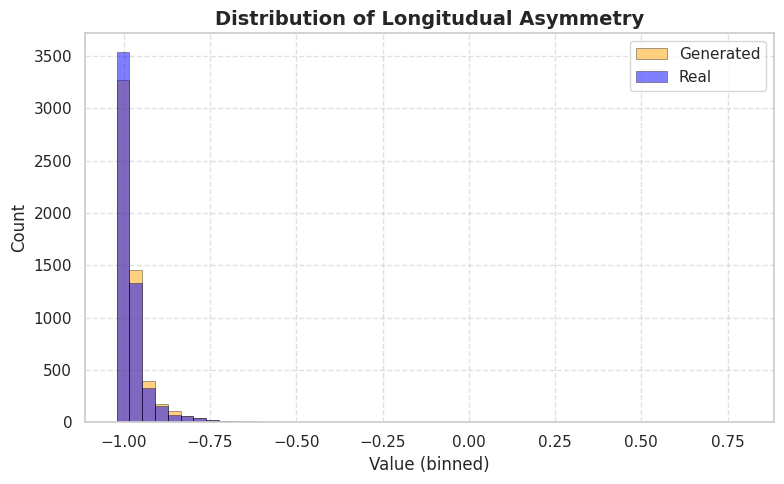

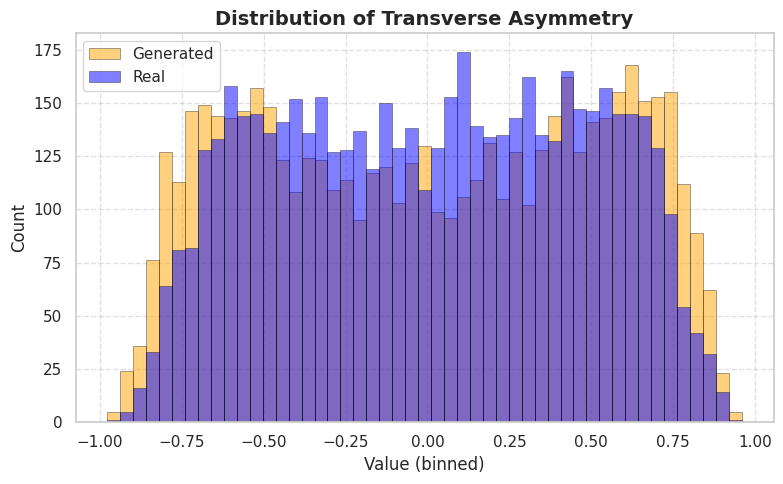

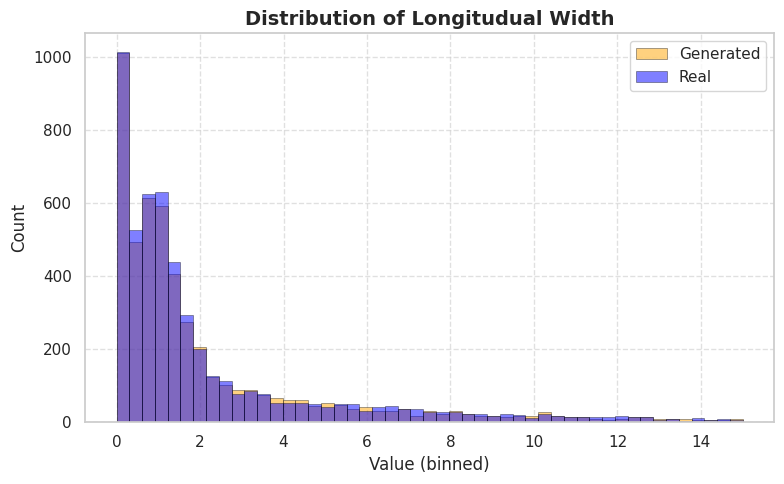

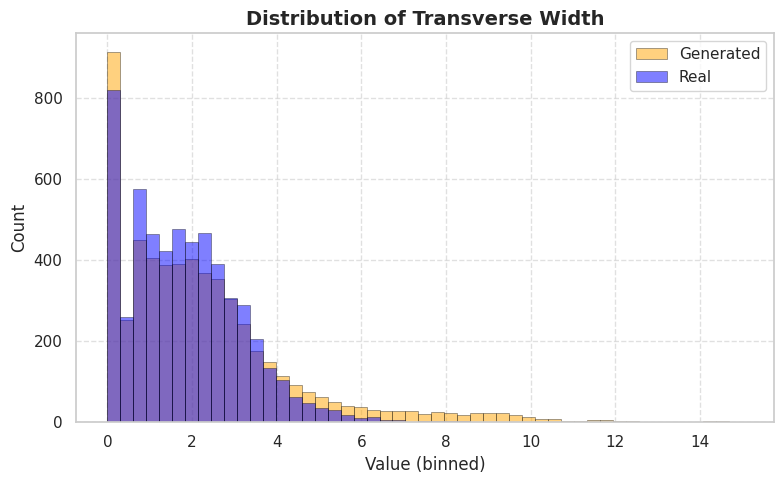

Energy PRD


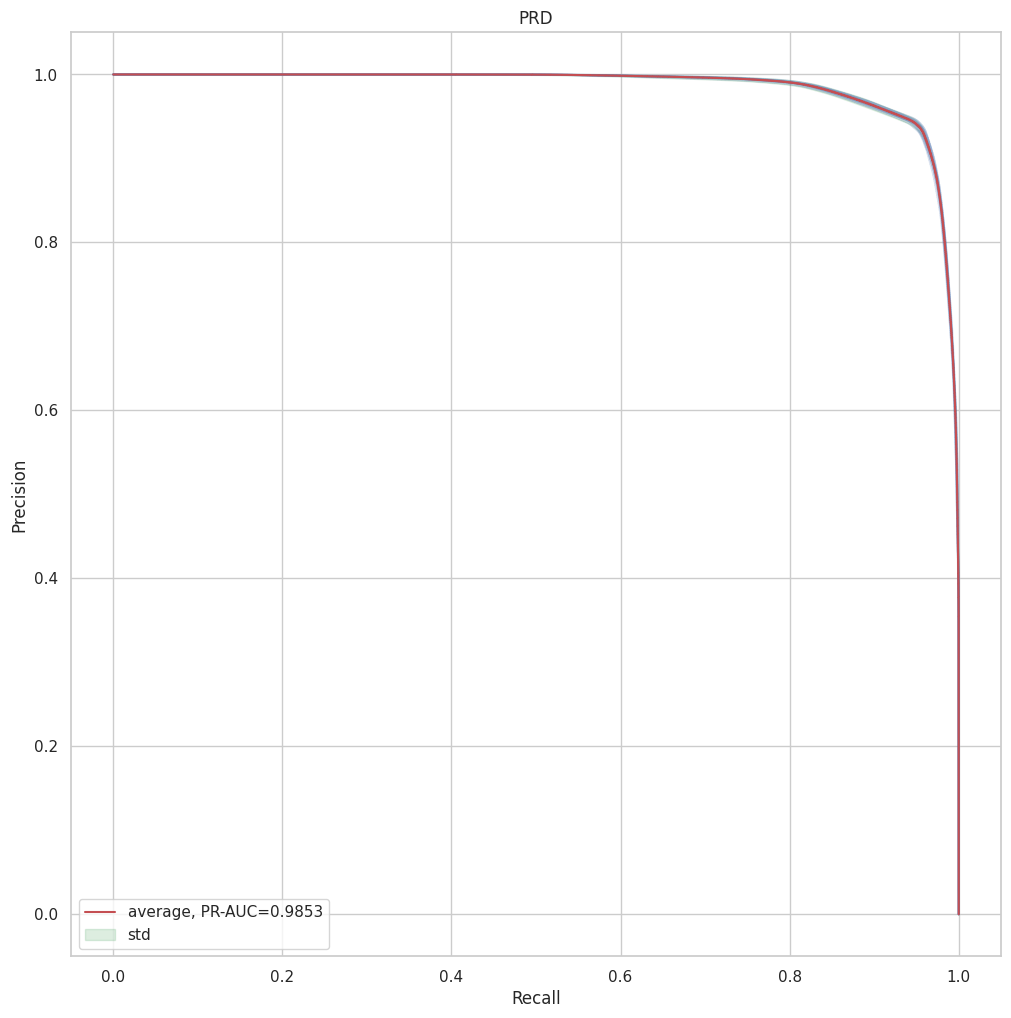

Physics PRD


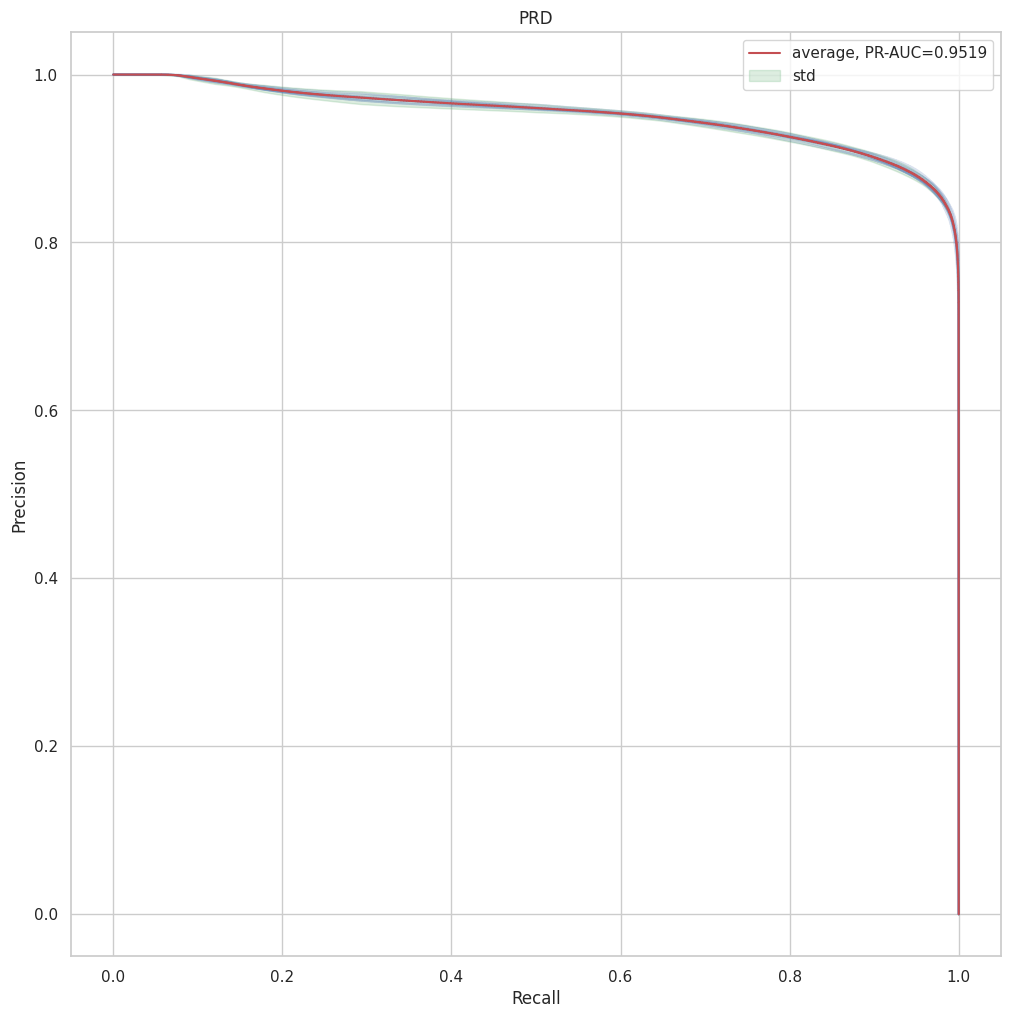

In [52]:
metric_calculator = DiffusionPhysicsMetrics()
metric_calculator.visualize_metrics(generated_images_valid, real_images_valid, conditions=conditions_valid)